In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers 
import scipy.stats as stats
import os 
import h5py
import sys
import tensorflow.keras.backend as K
import re
%matplotlib inline 

In [2]:
model_name = "subtract_lepphi_samecenter_sinLoss"

In [3]:
# Throw away lepton mass 
# os.chdir('./../../../../../data/hongtao')
be = h5py.File('./../../../../../data/hongtao/variables_tt_re.h5','r')
bmu = h5py.File('./../../../../../data/hongtao/variables_tt_rmu.h5','r')
be1 = h5py.File('./../../../../../data/hongtao/variables_tt_re1.h5','r')
print(be.keys())
print('')
print(be1.keys())
dataset = be1

<KeysViewHDF5 ['j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt', 'j8_eta', 'j8_isbtag', 'j8_m', 'j8_phi', 'j8_pt', 'lep_eta', 'lep_m', 'lep_phi', 'lep_pt', 'met_met', 'met_phi', 'mttReco', 'mttTrue']>

<KeysViewHDF5 ['bh_eta', 'bh_phi', 'bh_pt', 'bl_eta', 'bl_phi', 'bl_pt', 'j1_DL1r', 'j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_DL1r', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_DL1r', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_DL1r', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_DL1r', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_DL1r', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_DL1r', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt'

In [4]:
input_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'j7_pt', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi'] 
output_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi', 'wl_eta', 'wl_phi', 'wl_pt']
phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi', 'wl_phi']
eta_keys = ['j1_eta', 'j2_eta', 'j3_eta', 'j4_eta', 'j5_eta', 'j5_phi', 'j6_eta', 'lep_eta', 'th_eta', 'tl_eta', 'wl_eta']
pt_keys = ['j1_pt', 'j2_pt','j3_pt','j4_pt','j5_pt','j6_pt','lep_pt','th_pt', 'tl_pt', 'wl_pt']
m_keys = ['j1_m','j2_m', 'j3_m', 'j4_m', 'j5_m', 'j6_m']
DL1r_keys = ['j1_DL1r','j2_DL1r','j3_DL1r','j4_DL1r','j5_DL1r','j6_DL1r']

output_length = len(output_keys)
input_length = len(input_keys)
crop0 =  100000 

In [5]:
# plt.figure(figsize=(8,8*output_length))
# for i in range(0, output_length):
#     plt.subplot(output_length, 1, i+1)
#     plt.hist(dataset.get(output_keys[i]), 20, histtype='step')
#     plt.xlabel(output_keys[i])
#     plt.ylabel('Frequency')

In [6]:
lep_phi = np.array(dataset.get('lep_phi'))[0:crop0]


def phi_transform(arr, max0, mean):
    arr = (arr-mean)
    arr = arr/max0/1.01/2+0.5
    z = stats.norm.ppf(arr)/2.5
    return z 

def invphi_transform(z, max0, mean):
    arr = stats.norm.cdf(2.5*z)
    arr = (arr-0.5)*max0*1.01*2+mean
    return arr 

def jet_existence_dict():
    dic = {}
    for key in phi_keys:
        variable = key.split('_')[0]
        if bool(re.match('^j[0-9]+$', variable)): # If the variable is a jet
            v = np.array(dataset.get(variable + '_pt'))[0:crop0]
            dic[key] = (v>1)*1
        else:
            dic[key] = np.ones(crop0, dtype=int)
    return dic
        
def phi1_transform(arr, max0, mean, exist):
    w = (arr - lep_phi*exist) % (2*np.pi)
    x = w - 2*np.pi*(w>np.pi)
    y = x - (1-exist)*np.pi*1.1
    y = y-mean
    z = y/max0
    return z

def invphi1_transform(z, max0, mean, exist):
    y = z*max0+mean
    x = y+(1-exist)*np.pi*1.1
    w = x + 2*np.pi*(x<0)
    arr = (w + lep_phi*exist) % (2*np.pi)
    arr = arr - 2*np.pi*(arr > np.pi)
    return arr 


def phi2_transform(arr, max0, mean, exist):
    w = (arr - lep_phi*exist) % (2*np.pi)
    # x = w - 2*np.pi*(w>np.pi)
    y = w - (1-exist)*0.2
    z = y/(np.pi)
    return z

def invphi2_transform(z, max0, mean, exist):
    y = z*np.pi
    x = y+(1-exist)*0.2
    # w = x + 2*np.pi*(x<0)
    arr = (x + lep_phi*exist) % (2*np.pi)
    arr = arr - 2*np.pi*(arr > np.pi)
    return arr 

def phi3_transform(arr, max0, mean, exist):
    w = (arr - lep_phi*exist) % (2*np.pi)
    return np.sin(w) - 1.2*(1-exist), np.cos(w) - 2.2*(1-exist) 
    
def invphi3_transform(z1, z2, max0, mean, exist):
    w1 = z1 + 1.2*(1-exist)
    w2 = z2 + 2.2*(1-exist)
    w = np.arctan2(w1, w2)
    arr = (w + lep_phi*exist) % (2*np.pi)
    arr = arr - 2*np.pi*(arr > np.pi)
    return arr

def pt_transform(arr, max0, mean):
    return arr/max0

def invpt_transform(z, max0, mean):
    return z*max0 

def meanmax_transform(arr, max0, mean):
    arr = arr-mean
    z = arr/max0
    return z

def invmeanmax_transform(z, max0, mean):
    return z*max0+mean

def get_maxmean_dict(): 
    to_get = [pt_keys, eta_keys, m_keys, DL1r_keys]
    keys = ['pt', 'eta', 'm','DL1r']
    maxmean= {} 
    
    for i in range(4):
        dset = to_get[i]
        for x in dset:
            arr = []
            arr.append(np.array(dataset.get(x))[0:crop0])
        arr = np.stack(arr,axis=1)
        maxmean[keys[i]] = (np.max(np.abs(arr)), np.mean(arr))
    
    maxmean['phi'] = (np.pi, 0)
    maxmean['met'] = (np.max(np.abs(dataset.get('met_met'))), np.mean(dataset.get('met_met')))
    return maxmean 
    
def scale_arrays(keys, maxmean_dict):
    names = []
    exist_dict = jet_existence_dict()
    lep_phi = np.array(dataset.get('lep_phi'))[0:crop0]
    
    arrays = []
    for key in keys:
        var = np.array(dataset.get(key))[0:crop0]
        if key in phi_keys:
            max0, mean = maxmean_dict['phi']
            exist = exist_dict[key]
            zsin, zcos = phi3_transform(var, max0, mean, exist)
            arrays.append(zsin)
            arrays.append(zcos)
            names.append(key +'-sin')
            names.append(key + '-cos')
        else:
            if key in pt_keys:
                max0, mean = maxmean_dict['pt']
                z = pt_transform(var, max0, mean)
            elif key in m_keys:
                max0, mean = maxmean_dict['m']
                z = pt_transform(var, max0, mean)
            else:
                max0, mean = maxmean_dict[key.split('_')[1]]
                z = meanmax_transform(var, max0, mean)
            arrays.append(z)
            names.append(key)
    arrays = np.stack(arrays, axis=1)
    return arrays, names

def invscale_arrays(keys, arrays, maxmean_dict, names):
    exist_dict = jet_existence_dict()
    total = []
    i = 0
    while i< arrays.shape[1]:
        full_key = names[i]
        key = names[i].split('_')[1]
        if key[0:3] == 'phi':
            zsin = arrays
            max0, mean = maxmean_dict['phi']
            exist = exist_dict[full_key.split('-')[0]]
            zsin = arrays[:,i]
            zcos = arrays[:,i+1]
            total.append(invphi3_transform(zsin, zcos, max0, mean, exist))
            i+=2
        else:
            z=arrays[:,i]
            if key == 'pt':
                max0, mean = maxmean_dict[key]
                total.append(invpt_transform(z, max0, mean))
            elif key=='m':
                max0, mean = maxmean_dict[key]
                total.append(invpt_transform(z, max0, mean))
            else:
                max0, mean = maxmean_dict[key]
                total.append(invmeanmax_transform(z, max0, mean))
            i+=1
    return np.stack(total,axis=1) 

In [7]:
# Convert into numpy arrays and mean normalize

maxmean = get_maxmean_dict()
total_input, input_names = scale_arrays(input_keys, maxmean)

total_output, output_names = scale_arrays(output_keys, maxmean)
out_scaled = invscale_arrays(output_keys, total_output, maxmean, output_names)

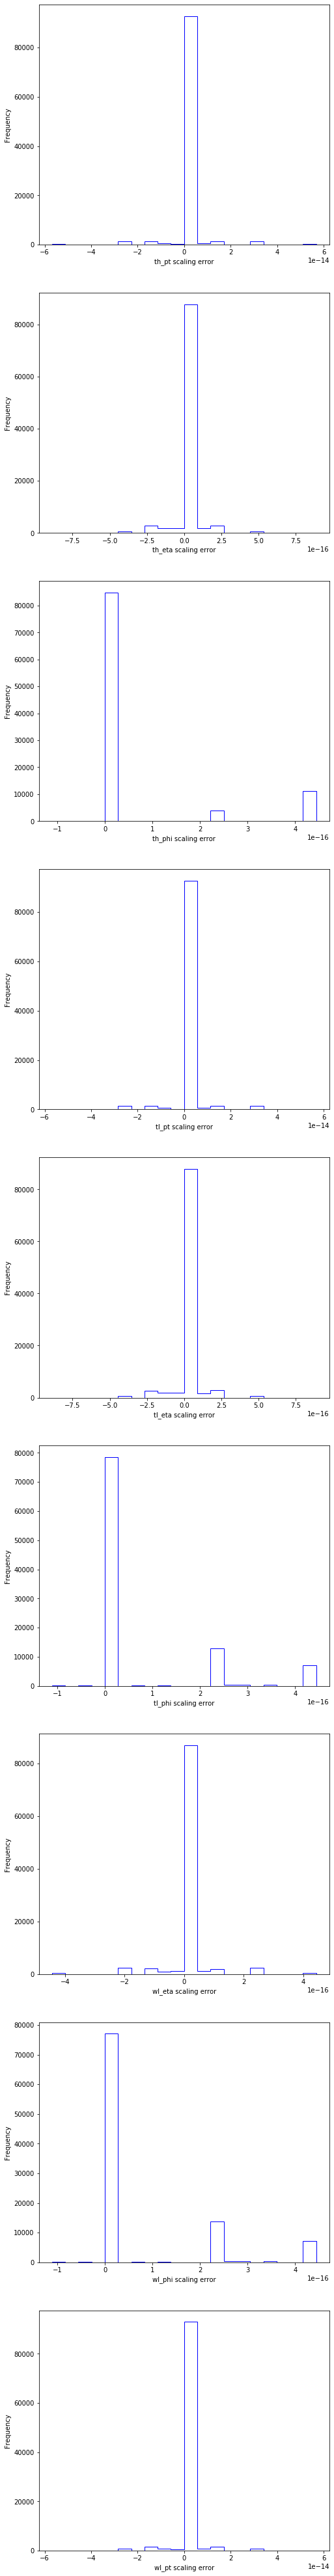

In [8]:
# Test inverse scaling

if True:
    plt.figure(figsize=(8,8*output_length))
    for i in range(len(output_keys)):
        plt.subplot(output_length, 1, i+1)
        plt.hist(dataset.get(output_keys[i])[0:crop0] - out_scaled[:, i], 20, histtype='step', color='b')
        plt.xlabel(output_keys[i] + " scaling error")
        plt.ylabel('Frequency')

In [9]:
# Create input and test array
split = int(np.floor(0.8*crop0)) # 80/20 split 
shuffle = False

if shuffle:
    rng_state = np.random.get_state()
    np.random.shuffle(total_input)
    np.random.set_state(rng_state)
    np.random.shuffle(total_output)
    
output_length = len(output_names) 
input_length = len(input_names) 

train_input, test_input = total_input[0:split, :], total_input[split:,:]
train_output, test_output = total_output[0:split,:], total_output[split:,:]

In [10]:
print(train_input.shape, train_output.shape)
print(test_input.shape, test_output.shape)

(80000, 44) (80000, 12)
(20000, 44) (20000, 12)


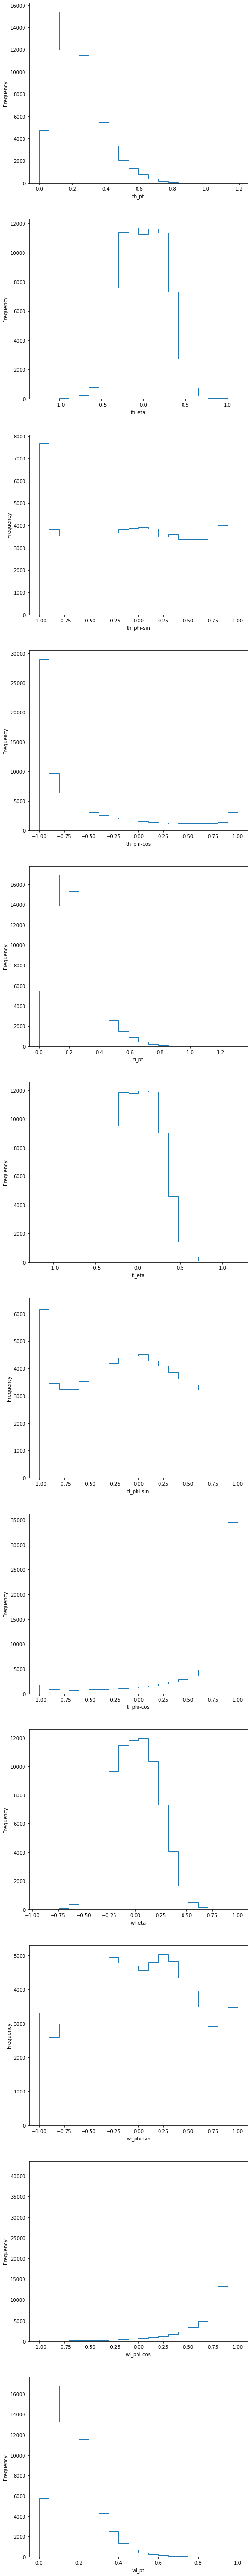

In [11]:
# Histograms of output variables 
show = True

if show:
    plt.figure(figsize=(8,8*output_length))
    for i in range(0, output_length):
        plt.subplot(output_length, 1, i+1)
        plt.hist(train_output[:,i], 20, histtype='step')
        plt.xlabel(output_names[i])
        plt.ylabel('Frequency')

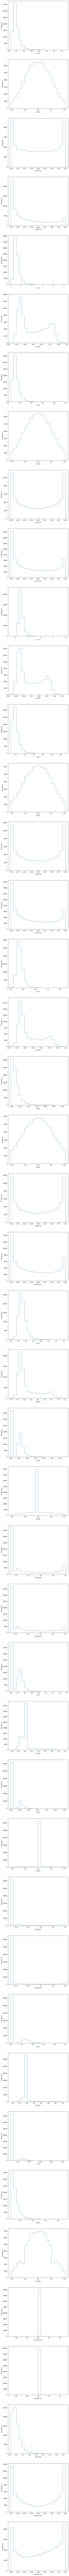

In [12]:
# Histograms of input variables 
show = True

if show:
    plt.figure(figsize=(8,8*input_length))
    for i in range(0, input_length):
        plt.subplot(input_length, 1, i+1)
        plt.hist(train_input[:,i], 20, histtype='step')
        plt.xlabel(input_names[i])
        plt.ylabel('Frequency')

 

In [21]:
# Build model

def custom_loss(tru, predict):
    return K.mean(K.square(K.sin(np.pi/2*(tru-predict))))

# optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5)
optimizer = keras.optimizers.Adam(learning_rate=1e-6)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


def build_model():
    model = keras.Sequential([
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001),
                     input_shape=[len(input_names)]),
        layers.Dense(256,  activation='relu'),
        layers.Dense(256,  activation='relu'),
        layers.Dense(256,  activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(output_names),  activation='linear')
    ])
    # losses = [custom_loss if output_names[i].split('_')[1] == 'phi' 
    #           else 'mse' for i in range(len(output_names))]
    
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    return model 

# def build_model():
#     model = keras.Sequential([
#         layers.Dense(6, activation='linear', 
#                      input_shape=[len(input_keys)])])
    
#     model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
#     return model 
    

In [22]:
model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               23040     
_________________________________________________________________
dense_25 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_26 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_27 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_28 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_29 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_30 (Dense)             (None, 128)              

In [23]:
# Fit model

Epochs= 2048

history = model.fit(train_input, train_output, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=False, callbacks=[callback],
                   batch_size=512)


Epoch 1/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.3080 - mse: 0.2997 - val_loss: 0.3042 - val_mse: 0.2960
Epoch 2/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.3012 - mse: 0.2930 - val_loss: 0.2981 - val_mse: 0.2899
Epoch 3/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.2957 - mse: 0.2875 - val_loss: 0.2930 - val_mse: 0.2848
Epoch 4/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.2910 - mse: 0.2828 - val_loss: 0.2885 - val_mse: 0.2803
Epoch 5/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.2868 - mse: 0.2786 - val_loss: 0.2845 - val_mse: 0.2763
Epoch 6/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.2829 - mse: 0.2747 - val_loss: 0.2806 - val_mse: 0.2724
Epoch 7/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.2790 - mse: 0.2709 - val_loss: 0.2766 - val_mse: 0.2685
Epoch 8/2048
125/125 [==============================] - 1s 5ms

Epoch 62/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1326 - mse: 0.1248 - val_loss: 0.1311 - val_mse: 0.1232
Epoch 63/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1323 - mse: 0.1245 - val_loss: 0.1308 - val_mse: 0.1229
Epoch 64/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1320 - mse: 0.1242 - val_loss: 0.1305 - val_mse: 0.1227
Epoch 65/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1317 - mse: 0.1239 - val_loss: 0.1302 - val_mse: 0.1224
Epoch 66/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1314 - mse: 0.1236 - val_loss: 0.1299 - val_mse: 0.1221
Epoch 67/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1311 - mse: 0.1233 - val_loss: 0.1296 - val_mse: 0.1218
Epoch 68/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1308 - mse: 0.1230 - val_loss: 0.1293 - val_mse: 0.1215
Epoch 69/2048
125/125 [==============================] 

125/125 [==============================] - 1s 5ms/step - loss: 0.1195 - mse: 0.1120 - val_loss: 0.1185 - val_mse: 0.1110
Epoch 123/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1194 - mse: 0.1119 - val_loss: 0.1183 - val_mse: 0.1108
Epoch 124/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1192 - mse: 0.1118 - val_loss: 0.1182 - val_mse: 0.1107
Epoch 125/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1191 - mse: 0.1116 - val_loss: 0.1181 - val_mse: 0.1106
Epoch 126/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1190 - mse: 0.1115 - val_loss: 0.1180 - val_mse: 0.1105
Epoch 127/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1189 - mse: 0.1114 - val_loss: 0.1179 - val_mse: 0.1104
Epoch 128/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1187 - mse: 0.1113 - val_loss: 0.1177 - val_mse: 0.1103
Epoch 129/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.1132 - mse: 0.1059 - val_loss: 0.1124 - val_mse: 0.1052
Epoch 183/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1131 - mse: 0.1058 - val_loss: 0.1123 - val_mse: 0.1051
Epoch 184/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1130 - mse: 0.1057 - val_loss: 0.1122 - val_mse: 0.1050
Epoch 185/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1129 - mse: 0.1057 - val_loss: 0.1121 - val_mse: 0.1049
Epoch 186/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1128 - mse: 0.1056 - val_loss: 0.1121 - val_mse: 0.1048
Epoch 187/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1127 - mse: 0.1055 - val_loss: 0.1120 - val_mse: 0.1048
Epoch 188/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1126 - mse: 0.1054 - val_loss: 0.1119 - val_mse: 0.1047
Epoch 189/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.1088 - mse: 0.1017 - val_loss: 0.1082 - val_mse: 0.1012
Epoch 243/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1087 - mse: 0.1016 - val_loss: 0.1082 - val_mse: 0.1011
Epoch 244/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1086 - mse: 0.1016 - val_loss: 0.1081 - val_mse: 0.1011
Epoch 245/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1086 - mse: 0.1015 - val_loss: 0.1081 - val_mse: 0.1010
Epoch 246/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1085 - mse: 0.1015 - val_loss: 0.1080 - val_mse: 0.1010
Epoch 247/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1085 - mse: 0.1014 - val_loss: 0.1080 - val_mse: 0.1009
Epoch 248/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1084 - mse: 0.1014 - val_loss: 0.1079 - val_mse: 0.1009
Epoch 249/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.1060 - mse: 0.0991 - val_loss: 0.1057 - val_mse: 0.0988
Epoch 303/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1060 - mse: 0.0991 - val_loss: 0.1057 - val_mse: 0.0988
Epoch 304/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1060 - mse: 0.0991 - val_loss: 0.1057 - val_mse: 0.0988
Epoch 305/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1059 - mse: 0.0990 - val_loss: 0.1056 - val_mse: 0.0988
Epoch 306/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1059 - mse: 0.0990 - val_loss: 0.1056 - val_mse: 0.0987
Epoch 307/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1059 - mse: 0.0990 - val_loss: 0.1056 - val_mse: 0.0987
Epoch 308/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1058 - mse: 0.0989 - val_loss: 0.1055 - val_mse: 0.0987
Epoch 309/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.1042 - mse: 0.0974 - val_loss: 0.1041 - val_mse: 0.0973
Epoch 363/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1041 - mse: 0.0974 - val_loss: 0.1041 - val_mse: 0.0973
Epoch 364/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1041 - mse: 0.0974 - val_loss: 0.1040 - val_mse: 0.0973
Epoch 365/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1041 - mse: 0.0973 - val_loss: 0.1040 - val_mse: 0.0973
Epoch 366/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1041 - mse: 0.0973 - val_loss: 0.1040 - val_mse: 0.0972
Epoch 367/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1040 - mse: 0.0973 - val_loss: 0.1040 - val_mse: 0.0972
Epoch 368/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1040 - mse: 0.0973 - val_loss: 0.1039 - val_mse: 0.0972
Epoch 369/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.1027 - mse: 0.0961 - val_loss: 0.1028 - val_mse: 0.0962
Epoch 423/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1027 - mse: 0.0960 - val_loss: 0.1028 - val_mse: 0.0962
Epoch 424/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1026 - mse: 0.0960 - val_loss: 0.1028 - val_mse: 0.0961
Epoch 425/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1026 - mse: 0.0960 - val_loss: 0.1028 - val_mse: 0.0961
Epoch 426/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1026 - mse: 0.0960 - val_loss: 0.1027 - val_mse: 0.0961
Epoch 427/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1026 - mse: 0.0960 - val_loss: 0.1027 - val_mse: 0.0961
Epoch 428/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1026 - mse: 0.0959 - val_loss: 0.1027 - val_mse: 0.0961
Epoch 429/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.1014 - mse: 0.0949 - val_loss: 0.1018 - val_mse: 0.0952
Epoch 483/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1014 - mse: 0.0949 - val_loss: 0.1017 - val_mse: 0.0952
Epoch 484/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1014 - mse: 0.0949 - val_loss: 0.1017 - val_mse: 0.0952
Epoch 485/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1014 - mse: 0.0949 - val_loss: 0.1017 - val_mse: 0.0952
Epoch 486/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1013 - mse: 0.0948 - val_loss: 0.1017 - val_mse: 0.0952
Epoch 487/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1013 - mse: 0.0948 - val_loss: 0.1017 - val_mse: 0.0952
Epoch 488/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1013 - mse: 0.0948 - val_loss: 0.1017 - val_mse: 0.0951
Epoch 489/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.1003 - mse: 0.0939 - val_loss: 0.1008 - val_mse: 0.0944
Epoch 543/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1003 - mse: 0.0939 - val_loss: 0.1008 - val_mse: 0.0944
Epoch 544/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1003 - mse: 0.0939 - val_loss: 0.1008 - val_mse: 0.0944
Epoch 545/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1003 - mse: 0.0938 - val_loss: 0.1008 - val_mse: 0.0944
Epoch 546/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1002 - mse: 0.0938 - val_loss: 0.1008 - val_mse: 0.0944
Epoch 547/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1002 - mse: 0.0938 - val_loss: 0.1008 - val_mse: 0.0944
Epoch 548/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.1002 - mse: 0.0938 - val_loss: 0.1008 - val_mse: 0.0943
Epoch 549/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0993 - mse: 0.0930 - val_loss: 0.1000 - val_mse: 0.0937
Epoch 603/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0993 - mse: 0.0929 - val_loss: 0.1000 - val_mse: 0.0937
Epoch 604/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0993 - mse: 0.0929 - val_loss: 0.1000 - val_mse: 0.0937
Epoch 605/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0992 - mse: 0.0929 - val_loss: 0.1000 - val_mse: 0.0937
Epoch 606/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0992 - mse: 0.0929 - val_loss: 0.1000 - val_mse: 0.0937
Epoch 607/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0992 - mse: 0.0929 - val_loss: 0.1000 - val_mse: 0.0936
Epoch 608/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0992 - mse: 0.0929 - val_loss: 0.1000 - val_mse: 0.0936
Epoch 609/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0984 - mse: 0.0921 - val_loss: 0.0993 - val_mse: 0.0930
Epoch 663/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0983 - mse: 0.0921 - val_loss: 0.0993 - val_mse: 0.0930
Epoch 664/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0983 - mse: 0.0921 - val_loss: 0.0993 - val_mse: 0.0930
Epoch 665/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0983 - mse: 0.0920 - val_loss: 0.0993 - val_mse: 0.0930
Epoch 666/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0983 - mse: 0.0920 - val_loss: 0.0993 - val_mse: 0.0930
Epoch 667/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0983 - mse: 0.0920 - val_loss: 0.0992 - val_mse: 0.0930
Epoch 668/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0983 - mse: 0.0920 - val_loss: 0.0992 - val_mse: 0.0930
Epoch 669/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0975 - mse: 0.0913 - val_loss: 0.0986 - val_mse: 0.0924
Epoch 723/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0975 - mse: 0.0913 - val_loss: 0.0986 - val_mse: 0.0924
Epoch 724/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0975 - mse: 0.0913 - val_loss: 0.0986 - val_mse: 0.0924
Epoch 725/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0974 - mse: 0.0912 - val_loss: 0.0986 - val_mse: 0.0924
Epoch 726/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0974 - mse: 0.0912 - val_loss: 0.0986 - val_mse: 0.0924
Epoch 727/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0974 - mse: 0.0912 - val_loss: 0.0986 - val_mse: 0.0924
Epoch 728/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0974 - mse: 0.0912 - val_loss: 0.0986 - val_mse: 0.0924
Epoch 729/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0967 - mse: 0.0905 - val_loss: 0.0980 - val_mse: 0.0919
Epoch 783/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0967 - mse: 0.0905 - val_loss: 0.0980 - val_mse: 0.0919
Epoch 784/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0966 - mse: 0.0905 - val_loss: 0.0980 - val_mse: 0.0919
Epoch 785/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0966 - mse: 0.0905 - val_loss: 0.0980 - val_mse: 0.0919
Epoch 786/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0966 - mse: 0.0905 - val_loss: 0.0980 - val_mse: 0.0918
Epoch 787/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0966 - mse: 0.0905 - val_loss: 0.0980 - val_mse: 0.0918
Epoch 788/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0966 - mse: 0.0905 - val_loss: 0.0980 - val_mse: 0.0918
Epoch 789/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0959 - mse: 0.0898 - val_loss: 0.0975 - val_mse: 0.0914
Epoch 843/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0959 - mse: 0.0898 - val_loss: 0.0975 - val_mse: 0.0914
Epoch 844/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0959 - mse: 0.0898 - val_loss: 0.0975 - val_mse: 0.0914
Epoch 845/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0959 - mse: 0.0898 - val_loss: 0.0974 - val_mse: 0.0914
Epoch 846/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0959 - mse: 0.0898 - val_loss: 0.0974 - val_mse: 0.0913
Epoch 847/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0958 - mse: 0.0898 - val_loss: 0.0974 - val_mse: 0.0913
Epoch 848/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0958 - mse: 0.0897 - val_loss: 0.0974 - val_mse: 0.0913
Epoch 849/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0952 - mse: 0.0891 - val_loss: 0.0970 - val_mse: 0.0909
Epoch 903/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0952 - mse: 0.0891 - val_loss: 0.0970 - val_mse: 0.0909
Epoch 904/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0952 - mse: 0.0891 - val_loss: 0.0969 - val_mse: 0.0909
Epoch 905/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0952 - mse: 0.0891 - val_loss: 0.0969 - val_mse: 0.0909
Epoch 906/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0951 - mse: 0.0891 - val_loss: 0.0969 - val_mse: 0.0909
Epoch 907/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0951 - mse: 0.0891 - val_loss: 0.0969 - val_mse: 0.0909
Epoch 908/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0951 - mse: 0.0891 - val_loss: 0.0969 - val_mse: 0.0909
Epoch 909/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0945 - mse: 0.0885 - val_loss: 0.0965 - val_mse: 0.0905
Epoch 963/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0945 - mse: 0.0885 - val_loss: 0.0965 - val_mse: 0.0905
Epoch 964/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0945 - mse: 0.0885 - val_loss: 0.0965 - val_mse: 0.0905
Epoch 965/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0945 - mse: 0.0885 - val_loss: 0.0965 - val_mse: 0.0905
Epoch 966/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0945 - mse: 0.0885 - val_loss: 0.0965 - val_mse: 0.0905
Epoch 967/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0945 - mse: 0.0885 - val_loss: 0.0965 - val_mse: 0.0905
Epoch 968/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0945 - mse: 0.0885 - val_loss: 0.0965 - val_mse: 0.0905
Epoch 969/2048
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0939 - mse: 0.0879 - val_loss: 0.0961 - val_mse: 0.0901
Epoch 1023/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0939 - mse: 0.0879 - val_loss: 0.0961 - val_mse: 0.0901
Epoch 1024/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0939 - mse: 0.0879 - val_loss: 0.0961 - val_mse: 0.0901
Epoch 1025/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0939 - mse: 0.0879 - val_loss: 0.0961 - val_mse: 0.0901
Epoch 1026/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0938 - mse: 0.0879 - val_loss: 0.0961 - val_mse: 0.0901
Epoch 1027/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0938 - mse: 0.0879 - val_loss: 0.0961 - val_mse: 0.0901
Epoch 1028/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0938 - mse: 0.0879 - val_loss: 0.0961 - val_mse: 0.0901
Epoch 1029/2048
125/125 [==============================] 

Epoch 1082/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0933 - mse: 0.0874 - val_loss: 0.0957 - val_mse: 0.0898
Epoch 1083/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0933 - mse: 0.0874 - val_loss: 0.0957 - val_mse: 0.0898
Epoch 1084/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0933 - mse: 0.0873 - val_loss: 0.0957 - val_mse: 0.0898
Epoch 1085/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0933 - mse: 0.0873 - val_loss: 0.0957 - val_mse: 0.0898
Epoch 1086/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0933 - mse: 0.0873 - val_loss: 0.0957 - val_mse: 0.0898
Epoch 1087/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0932 - mse: 0.0873 - val_loss: 0.0957 - val_mse: 0.0898
Epoch 1088/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0932 - mse: 0.0873 - val_loss: 0.0957 - val_mse: 0.0898
Epoch 1089/2048
125/125 [================

Epoch 1142/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0927 - mse: 0.0868 - val_loss: 0.0954 - val_mse: 0.0895
Epoch 1143/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0927 - mse: 0.0868 - val_loss: 0.0954 - val_mse: 0.0895
Epoch 1144/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0927 - mse: 0.0868 - val_loss: 0.0954 - val_mse: 0.0895
Epoch 1145/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0927 - mse: 0.0868 - val_loss: 0.0954 - val_mse: 0.0895
Epoch 1146/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0927 - mse: 0.0868 - val_loss: 0.0954 - val_mse: 0.0895
Epoch 1147/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0927 - mse: 0.0868 - val_loss: 0.0954 - val_mse: 0.0895
Epoch 1148/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0927 - mse: 0.0868 - val_loss: 0.0954 - val_mse: 0.0895
Epoch 1149/2048
125/125 [================

Epoch 1202/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0922 - mse: 0.0863 - val_loss: 0.0951 - val_mse: 0.0892
Epoch 1203/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0922 - mse: 0.0863 - val_loss: 0.0951 - val_mse: 0.0892
Epoch 1204/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0922 - mse: 0.0863 - val_loss: 0.0951 - val_mse: 0.0892
Epoch 1205/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0922 - mse: 0.0863 - val_loss: 0.0951 - val_mse: 0.0892
Epoch 1206/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0922 - mse: 0.0863 - val_loss: 0.0951 - val_mse: 0.0892
Epoch 1207/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0922 - mse: 0.0863 - val_loss: 0.0951 - val_mse: 0.0892
Epoch 1208/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0921 - mse: 0.0863 - val_loss: 0.0951 - val_mse: 0.0892
Epoch 1209/2048
125/125 [================

Epoch 1262/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0917 - mse: 0.0859 - val_loss: 0.0948 - val_mse: 0.0890
Epoch 1263/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0917 - mse: 0.0859 - val_loss: 0.0948 - val_mse: 0.0890
Epoch 1264/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0917 - mse: 0.0859 - val_loss: 0.0948 - val_mse: 0.0890
Epoch 1265/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0917 - mse: 0.0859 - val_loss: 0.0948 - val_mse: 0.0890
Epoch 1266/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0917 - mse: 0.0858 - val_loss: 0.0948 - val_mse: 0.0890
Epoch 1267/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0917 - mse: 0.0858 - val_loss: 0.0948 - val_mse: 0.0890
Epoch 1268/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0916 - mse: 0.0858 - val_loss: 0.0948 - val_mse: 0.0890
Epoch 1269/2048
125/125 [================

Epoch 1322/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0912 - mse: 0.0854 - val_loss: 0.0946 - val_mse: 0.0888
Epoch 1323/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0912 - mse: 0.0854 - val_loss: 0.0946 - val_mse: 0.0888
Epoch 1324/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0912 - mse: 0.0854 - val_loss: 0.0946 - val_mse: 0.0888
Epoch 1325/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0912 - mse: 0.0854 - val_loss: 0.0946 - val_mse: 0.0888
Epoch 1326/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0912 - mse: 0.0854 - val_loss: 0.0946 - val_mse: 0.0888
Epoch 1327/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0912 - mse: 0.0854 - val_loss: 0.0945 - val_mse: 0.0888
Epoch 1328/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0912 - mse: 0.0854 - val_loss: 0.0945 - val_mse: 0.0888
Epoch 1329/2048
125/125 [================

Epoch 1382/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0908 - mse: 0.0850 - val_loss: 0.0943 - val_mse: 0.0886
Epoch 1383/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0907 - mse: 0.0850 - val_loss: 0.0943 - val_mse: 0.0886
Epoch 1384/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0907 - mse: 0.0850 - val_loss: 0.0943 - val_mse: 0.0886
Epoch 1385/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0907 - mse: 0.0850 - val_loss: 0.0943 - val_mse: 0.0886
Epoch 1386/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0907 - mse: 0.0850 - val_loss: 0.0943 - val_mse: 0.0886
Epoch 1387/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0907 - mse: 0.0850 - val_loss: 0.0943 - val_mse: 0.0886
Epoch 1388/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0907 - mse: 0.0850 - val_loss: 0.0943 - val_mse: 0.0886
Epoch 1389/2048
125/125 [================

Epoch 1442/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0903 - mse: 0.0846 - val_loss: 0.0941 - val_mse: 0.0884
Epoch 1443/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0903 - mse: 0.0846 - val_loss: 0.0941 - val_mse: 0.0884
Epoch 1444/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0903 - mse: 0.0846 - val_loss: 0.0941 - val_mse: 0.0884
Epoch 1445/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0903 - mse: 0.0846 - val_loss: 0.0941 - val_mse: 0.0884
Epoch 1446/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0903 - mse: 0.0846 - val_loss: 0.0941 - val_mse: 0.0884
Epoch 1447/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0903 - mse: 0.0846 - val_loss: 0.0941 - val_mse: 0.0884
Epoch 1448/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0903 - mse: 0.0845 - val_loss: 0.0941 - val_mse: 0.0884
Epoch 1449/2048
125/125 [================

Epoch 1502/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0899 - mse: 0.0842 - val_loss: 0.0940 - val_mse: 0.0883
Epoch 1503/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0899 - mse: 0.0842 - val_loss: 0.0940 - val_mse: 0.0883
Epoch 1504/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0899 - mse: 0.0842 - val_loss: 0.0940 - val_mse: 0.0883
Epoch 1505/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0899 - mse: 0.0842 - val_loss: 0.0940 - val_mse: 0.0883
Epoch 1506/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0899 - mse: 0.0842 - val_loss: 0.0940 - val_mse: 0.0883
Epoch 1507/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0899 - mse: 0.0842 - val_loss: 0.0939 - val_mse: 0.0883
Epoch 1508/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0899 - mse: 0.0842 - val_loss: 0.0939 - val_mse: 0.0882
Epoch 1509/2048
125/125 [================

Epoch 1562/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0895 - mse: 0.0838 - val_loss: 0.0938 - val_mse: 0.0881
Epoch 1563/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0895 - mse: 0.0838 - val_loss: 0.0938 - val_mse: 0.0881
Epoch 1564/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0895 - mse: 0.0838 - val_loss: 0.0938 - val_mse: 0.0881
Epoch 1565/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0895 - mse: 0.0838 - val_loss: 0.0938 - val_mse: 0.0881
Epoch 1566/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0895 - mse: 0.0838 - val_loss: 0.0938 - val_mse: 0.0881
Epoch 1567/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0895 - mse: 0.0838 - val_loss: 0.0938 - val_mse: 0.0881
Epoch 1568/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0894 - mse: 0.0838 - val_loss: 0.0938 - val_mse: 0.0881
Epoch 1569/2048
125/125 [================

Epoch 1622/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0891 - mse: 0.0835 - val_loss: 0.0937 - val_mse: 0.0880
Epoch 1623/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0891 - mse: 0.0834 - val_loss: 0.0937 - val_mse: 0.0880
Epoch 1624/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0891 - mse: 0.0834 - val_loss: 0.0937 - val_mse: 0.0880
Epoch 1625/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0891 - mse: 0.0834 - val_loss: 0.0937 - val_mse: 0.0880
Epoch 1626/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0891 - mse: 0.0834 - val_loss: 0.0937 - val_mse: 0.0880
Epoch 1627/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0891 - mse: 0.0834 - val_loss: 0.0937 - val_mse: 0.0880
Epoch 1628/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0891 - mse: 0.0834 - val_loss: 0.0936 - val_mse: 0.0880
Epoch 1629/2048
125/125 [================

Epoch 1682/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0887 - mse: 0.0831 - val_loss: 0.0935 - val_mse: 0.0879
Epoch 1683/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0887 - mse: 0.0831 - val_loss: 0.0935 - val_mse: 0.0879
Epoch 1684/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0887 - mse: 0.0831 - val_loss: 0.0935 - val_mse: 0.0879
Epoch 1685/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0887 - mse: 0.0831 - val_loss: 0.0935 - val_mse: 0.0879
Epoch 1686/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0887 - mse: 0.0831 - val_loss: 0.0935 - val_mse: 0.0879
Epoch 1687/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0887 - mse: 0.0831 - val_loss: 0.0935 - val_mse: 0.0879
Epoch 1688/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0887 - mse: 0.0831 - val_loss: 0.0935 - val_mse: 0.0879
Epoch 1689/2048
125/125 [================

Epoch 1742/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0883 - mse: 0.0827 - val_loss: 0.0934 - val_mse: 0.0878
Epoch 1743/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0883 - mse: 0.0827 - val_loss: 0.0934 - val_mse: 0.0878
Epoch 1744/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0883 - mse: 0.0827 - val_loss: 0.0934 - val_mse: 0.0878
Epoch 1745/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0883 - mse: 0.0827 - val_loss: 0.0934 - val_mse: 0.0878
Epoch 1746/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0883 - mse: 0.0827 - val_loss: 0.0934 - val_mse: 0.0878
Epoch 1747/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0883 - mse: 0.0827 - val_loss: 0.0934 - val_mse: 0.0878
Epoch 1748/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0883 - mse: 0.0827 - val_loss: 0.0934 - val_mse: 0.0878
Epoch 1749/2048
125/125 [================

Epoch 1802/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0880 - mse: 0.0824 - val_loss: 0.0933 - val_mse: 0.0878
Epoch 1803/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0880 - mse: 0.0824 - val_loss: 0.0933 - val_mse: 0.0878
Epoch 1804/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0880 - mse: 0.0824 - val_loss: 0.0933 - val_mse: 0.0878
Epoch 1805/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0880 - mse: 0.0824 - val_loss: 0.0933 - val_mse: 0.0877
Epoch 1806/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0879 - mse: 0.0824 - val_loss: 0.0933 - val_mse: 0.0877
Epoch 1807/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0879 - mse: 0.0824 - val_loss: 0.0933 - val_mse: 0.0877
Epoch 1808/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0879 - mse: 0.0824 - val_loss: 0.0933 - val_mse: 0.0877
Epoch 1809/2048
125/125 [================

Epoch 1862/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0876 - mse: 0.0821 - val_loss: 0.0932 - val_mse: 0.0877
Epoch 1863/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0876 - mse: 0.0821 - val_loss: 0.0932 - val_mse: 0.0877
Epoch 1864/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0876 - mse: 0.0821 - val_loss: 0.0932 - val_mse: 0.0877
Epoch 1865/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0876 - mse: 0.0821 - val_loss: 0.0932 - val_mse: 0.0877
Epoch 1866/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0876 - mse: 0.0821 - val_loss: 0.0932 - val_mse: 0.0877
Epoch 1867/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0876 - mse: 0.0820 - val_loss: 0.0932 - val_mse: 0.0877
Epoch 1868/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0876 - mse: 0.0820 - val_loss: 0.0932 - val_mse: 0.0877
Epoch 1869/2048
125/125 [================

Epoch 1922/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0873 - mse: 0.0818 - val_loss: 0.0931 - val_mse: 0.0876
Epoch 1923/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0873 - mse: 0.0817 - val_loss: 0.0931 - val_mse: 0.0876
Epoch 1924/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0873 - mse: 0.0817 - val_loss: 0.0931 - val_mse: 0.0876
Epoch 1925/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0872 - mse: 0.0817 - val_loss: 0.0931 - val_mse: 0.0876
Epoch 1926/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0872 - mse: 0.0817 - val_loss: 0.0931 - val_mse: 0.0876
Epoch 1927/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0872 - mse: 0.0817 - val_loss: 0.0931 - val_mse: 0.0876
Epoch 1928/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0872 - mse: 0.0817 - val_loss: 0.0931 - val_mse: 0.0876
Epoch 1929/2048
125/125 [================

125/125 [==============================] - 1s 5ms/step - loss: 0.0869 - mse: 0.0814 - val_loss: 0.0931 - val_mse: 0.0876
Epoch 1982/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0869 - mse: 0.0814 - val_loss: 0.0931 - val_mse: 0.0876
Epoch 1983/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0869 - mse: 0.0814 - val_loss: 0.0931 - val_mse: 0.0876
Epoch 1984/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0869 - mse: 0.0814 - val_loss: 0.0931 - val_mse: 0.0876
Epoch 1985/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0869 - mse: 0.0814 - val_loss: 0.0931 - val_mse: 0.0876
Epoch 1986/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0869 - mse: 0.0814 - val_loss: 0.0931 - val_mse: 0.0876
Epoch 1987/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0869 - mse: 0.0814 - val_loss: 0.0931 - val_mse: 0.0876
Epoch 1988/2048
125/125 [==============================] 

Epoch 2041/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0866 - mse: 0.0811 - val_loss: 0.0930 - val_mse: 0.0875
Epoch 2042/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0866 - mse: 0.0811 - val_loss: 0.0930 - val_mse: 0.0875
Epoch 2043/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0866 - mse: 0.0811 - val_loss: 0.0930 - val_mse: 0.0875
Epoch 2044/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0866 - mse: 0.0811 - val_loss: 0.0930 - val_mse: 0.0875
Epoch 2045/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0866 - mse: 0.0811 - val_loss: 0.0930 - val_mse: 0.0875
Epoch 2046/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0866 - mse: 0.0811 - val_loss: 0.0930 - val_mse: 0.0875
Epoch 2047/2048
125/125 [==============================] - 1s 5ms/step - loss: 0.0866 - mse: 0.0811 - val_loss: 0.0930 - val_mse: 0.0875
Epoch 2048/2048
125/125 [================

In [24]:
history.history.keys()
model.save(model_name)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: subtract_lepphi_samecenter_sinLoss/assets


Text(0.5, 1.0, 'MSE loss')

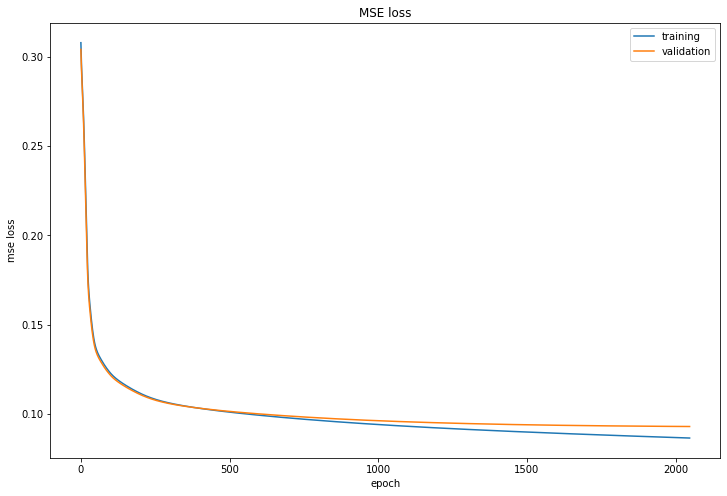

In [25]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [26]:
predictions = model.predict(test_input)

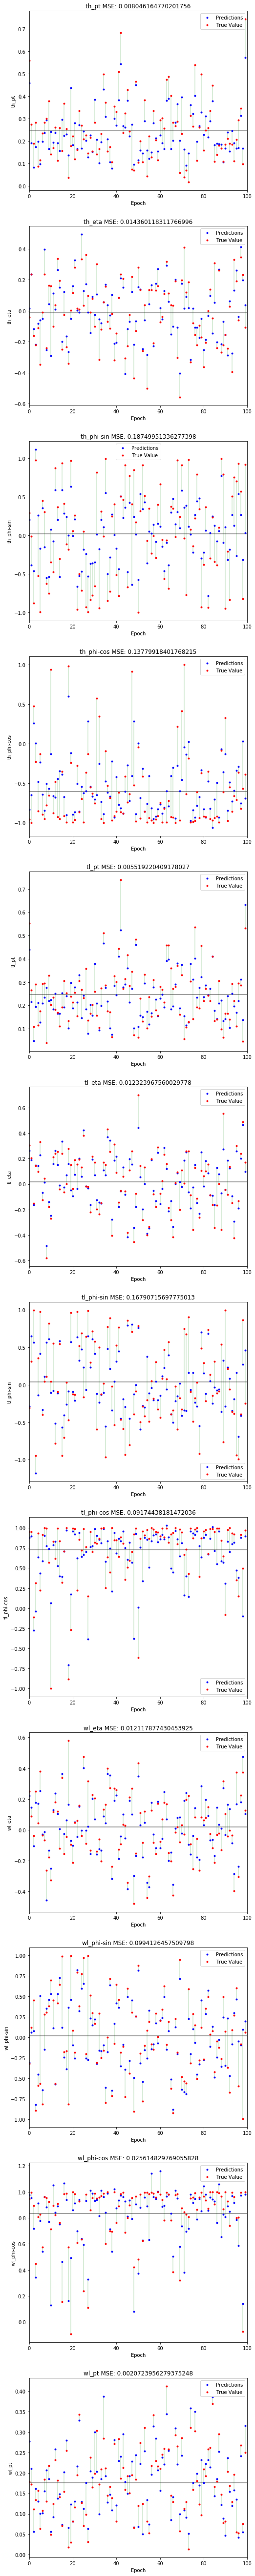

In [28]:

# Training 
crop = 100 

train_small = model.predict(train_input[0:100,:])
output_small = train_output[0:100,:]

def comparison_plot(compare, true):
    plt.figure(figsize=(8,8*output_length))
    for i in range(0,output_length):
        plt.subplot(output_length,1,i+1)
        plt.plot(range(0,crop), compare[:,i], 'bo', markersize=3, label = 'Predictions')
        plt.plot(range(0,crop), true[:,i], 'ro', markersize=3, label = 'True Value')
        ym, yM = plt.ylim()
        for x in range(100):
            plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                        min(compare[x,i], true[x,i]), 
                        ymax= max(compare[x,i], true[x,i]))
        plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=crop+20, alpha=0.5)
        MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
        plt.xlabel('Epoch')
        plt.ylabel(output_names[i])
        plt.xlim(0, crop)
        plt.title(output_names[i] + " MSE: " + str(MSE))
        plt.legend()

comparison_plot(train_small, output_small)

In [30]:
# Predictions

predictions_small = predictions[0:100,:]
test_output_small = test_output[0:100,:]

MSE = 1/predictions.size*np.sum((predictions- test_output)**2)
print("total MSE: " + str(MSE))

for i in range(output_length):
    MSE = 1/predictions[:,i].size*np.sum((predictions[:,i] -test_output[:,i])**2)
    print("{0} MSE : ".format(output_names[i]), '%.10f'%MSE)

total MSE: 0.08759120486024673
th_pt MSE :  0.0073353675
th_eta MSE :  0.0211331577
th_phi-sin MSE :  0.2726930758
th_phi-cos MSE :  0.2187306410
tl_pt MSE :  0.0059905056
tl_eta MSE :  0.0163431618
tl_phi-sin MSE :  0.2071930263
tl_phi-cos MSE :  0.1427669795
wl_eta MSE :  0.0102655418
wl_phi-sin MSE :  0.0970749123
wl_phi-cos MSE :  0.0484016384
wl_pt MSE :  0.0031664506


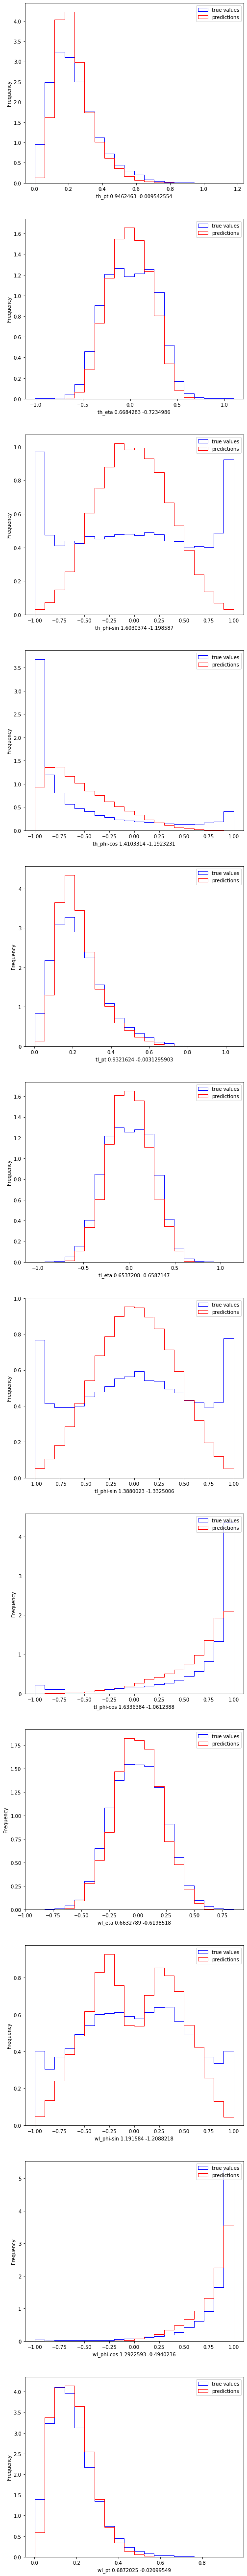

In [32]:
# Unscaled Histograms 

plt.figure(figsize=(8,8*output_length))
for i in range(len(output_names)):
    plt.subplot(output_length, 1, i+1)
    hist0, bin_edges = np.histogram(test_output[:, i], bins=20)
    plt.hist(test_output[:,i], bin_edges, histtype='step', color='b', label='true values', density=True)
    plt.hist(predictions[:,i], bin_edges, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(output_names[i] +" " +str(np.max(predictions[:,i])) + " " + str(np.min(predictions[:,i])))
    plt.legend()
    plt.ylabel('Frequency')

In [33]:
total_output, _ = scale_arrays(output_keys, maxmean)
out_scaled = invscale_arrays(output_keys, total_output, maxmean, output_names)[split:,:]

total_predictions = model.predict(total_input)
predict_scaled = invscale_arrays(output_keys, total_predictions, maxmean, output_names)[split:,:]

output_length = predict_scaled.shape[1]

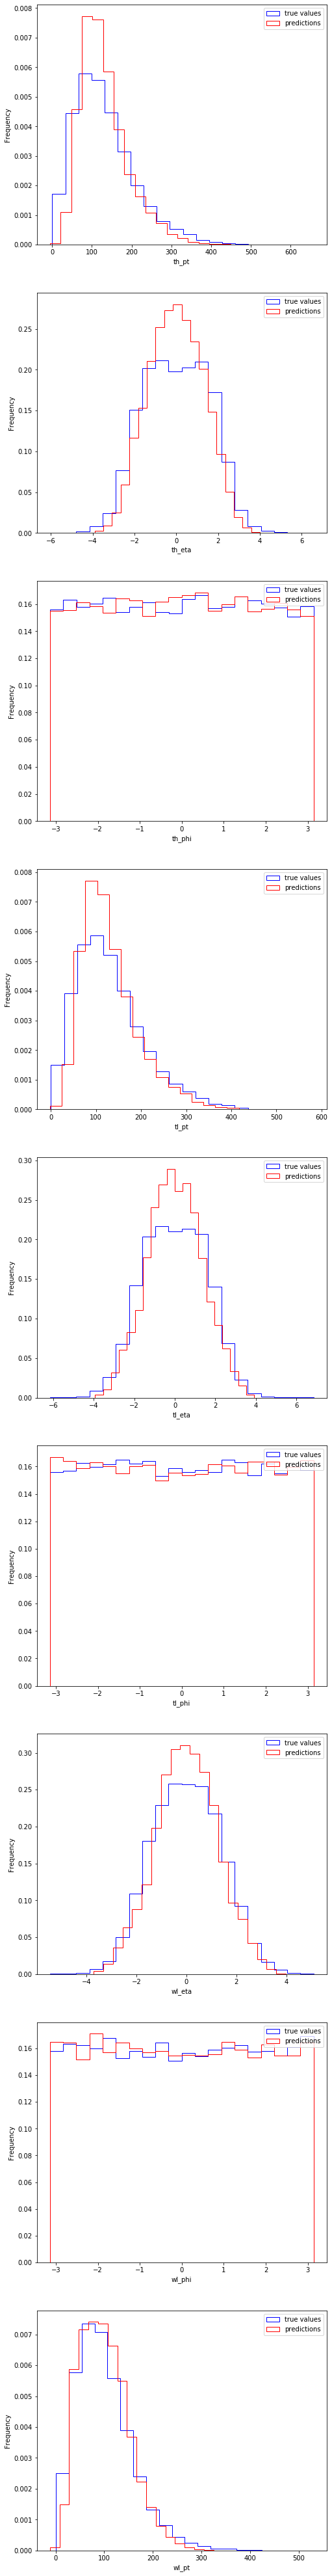

In [34]:
# Histograms to the original scale 

# out_scaled = invscale_arrays(output_keys, out_max0, out_mean, total_output)
# out_scaled = invscale_arrays(output_keys, test_output, maxmean)
# predict_scaled = invscale_arrays(output_keys, out_max0, out_mean, total_predictions)[split:,:]


plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    plt.hist(out_scaled[:, i], 20, histtype='step', color='b', label='true values', density=True)
    plt.hist(predict_scaled[:, i], 20, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(output_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

In [35]:
for i in range(output_length):
    if output_keys[i].split("_")[1] == 'phi':
        mod_pi = (predict_scaled[:,i] - out_scaled[:,i]) % (2*np.pi)
        mod_pi = mod_pi - 2*np.pi*(mod_pi > np.pi)
        MSE = 1/predict_scaled[:,i].size*np.sum((mod_pi)**2)
    else:
        MSE = 1/predict_scaled[:,i].size*np.sum((predict_scaled[:,i] - out_scaled[:,i])**2)
    print("Original Scale {0} MSE : ".format(output_keys[i]), '%.10f'%MSE)

Original Scale th_pt MSE :  2293.4640712988
Original Scale th_eta MSE :  0.7568186411
Original Scale th_phi MSE :  0.9647159761
Original Scale tl_pt MSE :  1872.9817503229
Original Scale tl_eta MSE :  0.5852797614
Original Scale tl_phi MSE :  0.6220689129
Original Scale wl_eta MSE :  0.3676286105
Original Scale wl_phi MSE :  0.2198977090
Original Scale wl_pt MSE :  990.0173039321


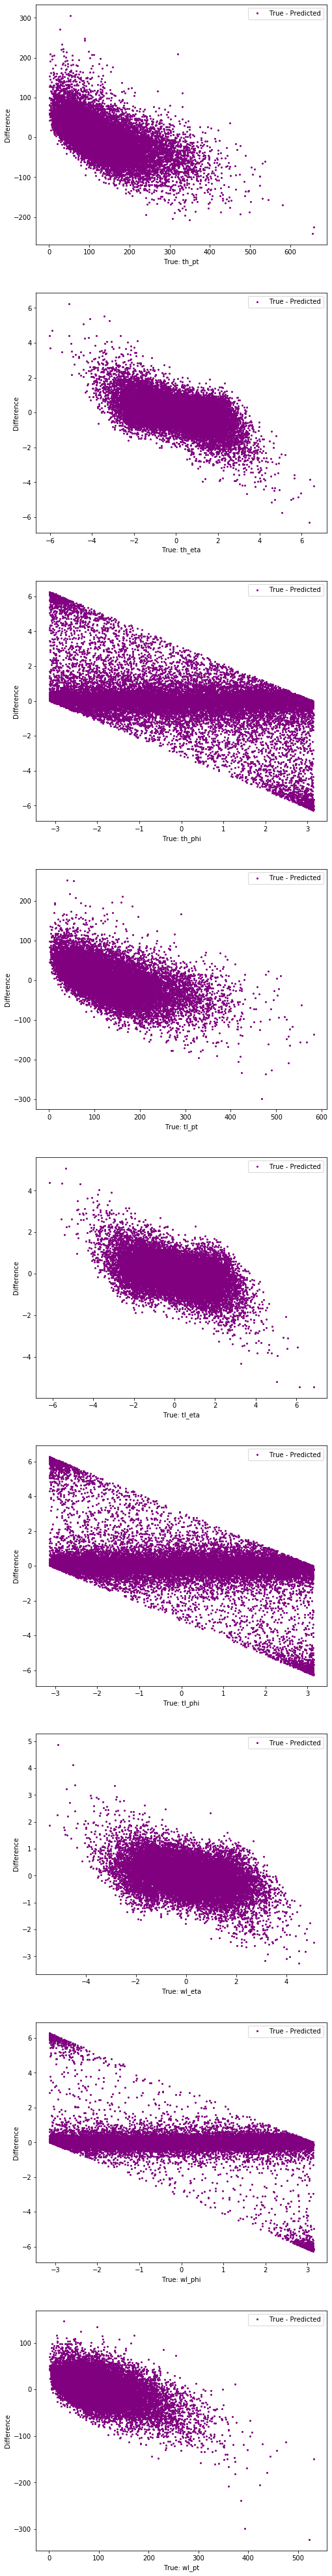

In [36]:
plt.figure(figsize=(8,8*output_length))
for i in range(output_length):
    plt.subplot(output_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    plt.plot(out_scaled[:, i], predict_scaled[:, i]-out_scaled[:, i], 'o', color='purple', label='True - Predicted', markersize=2)
    plt.xlabel('True: ' + output_keys[i])
    plt.legend()
    plt.ylabel('Difference')